In [1]:
%matplotlib inline
import os
import glob
import numpy as np
from tqdm import tqdm
from skimage.io import imread
from matplotlib import pyplot as plt
from multiprocessing import Pool
import threading

def concurrent_map(func, data):
    N = len(data)
    result = [None] * N
    def task_wrapper(i):
        result[i] = func(data[i])
    threads = [threading.Thread(target=task_wrapper, args=(i,)) for i in range(N)]
    for t in threads: t.start()
    for t in threads: t.join()
    return result

DATASET_ROOT = './CroppedYale/'
SPLIT_P = 35

In [2]:
# Define SSD, SAD, NN
SSD = lambda x, y: np.sum(np.square(x-y), axis=(1, 2)) # args: (element, set of images) output shape: (n_img,)
SAD = lambda x, y: np.sum(np.abs(x-y), axis=(1, 2))
NN = lambda p, Q, L, D: L[np.argmin(D(p, Q), axis=0)] # args: instance, train set, train label, distance method

In [3]:
# Construct filepaths.
label_name = sorted(next(os.walk(DATASET_ROOT))[1])

In [4]:
# Load images and split into train/val sets.
X_train, X_test, Y_train, Y_test = [], [], [], []
for id_, name in tqdm(enumerate(label_name), total=len(label_name)):
    img_paths = sorted(glob.glob(DATASET_ROOT+name+'/*.pgm')) # requirement of assignment 1
    train_paths, test_paths = img_paths[:SPLIT_P], img_paths[SPLIT_P:]
    X_train.extend([imread(img_path, as_grey=True) for img_path in train_paths])
    Y_train.extend([id_]*len(train_paths))
    X_test.extend([imread(img_path, as_grey=True) for img_path in test_paths])
    Y_test.extend([id_]*len(test_paths))
X_train, X_test, Y_train, Y_test = list(map(np.array, [X_train, X_test, Y_train, Y_test]))

100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:08<00:00,  4.64it/s]


In [5]:
# Define nearest neighbor methods
def SSD_NN(x): return NN(x, X_train, Y_train, SSD) # Don't use lambda due to pickle error
def SAD_NN(x): return NN(x, X_train, Y_train, SAD)

In [6]:
Y_test_pred_ssd = np.array(list(concurrent_map(SSD_NN, X_test)))
Y_test_pred_sad = np.array(list(concurrent_map(SAD_NN, X_test)))

In [7]:
print('SSD acc: %.2f%%'%(np.mean(Y_test_pred_ssd == Y_test)*100.))
print('SAD acc: %.2f%%'%(np.mean(Y_test_pred_sad == Y_test)*100.))

SSD acc: 24.52%
SAD acc: 18.80%


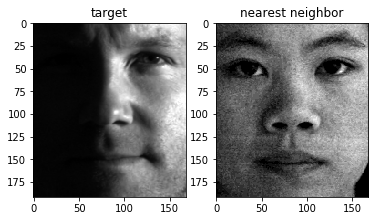

In [8]:
index = np.random.randint(0, len(Y_test))
nn = X_train[np.argmin(SSD(X_test[index], X_train), axis=0)]
plt.figure()
plt.subplot(1,2,1)
plt.title('target')
plt.imshow(X_test[index], cmap='gray')
plt.subplot(1,2,2)
plt.title('nearest neighbor')
plt.imshow(nn, cmap='gray')